https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-prophet-in-python-3

In [1]:
# evaluate mlp for monthly car sales dataset
from math import sqrt
from numpy import array
from numpy import mean
from numpy import std
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot
%matplotlib inline  
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# Python
import pandas as pd
import numpy as np
import datetime
from fbprophet import Prophet
def parse_date (x): 
    return datetime.datetime.strptime("0"+str(x), '%y-%m') 

In [ ]:
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))
measure_rmse([1,2],[1,3])

In [ ]:
#train_test_split([1,2,3,4,5],2)
def train_test_split(data, n_train):
    train = data.iloc[:n_train]
    test = data.iloc[n_train:]
    return train,test

In [ ]:
def prophet_predict(series):
    series.head()
    m = Prophet(mcmc_samples=500,seasonality_mode='multiplicative').fit(series);
    future = m.make_future_dataframe(periods=1,freq='M')
    forecast = m.predict(future)
    return forecast.iloc[-1]["yhat"]

In [ ]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_train, method, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_train)
    # seed history with training dataset
    #history = [x for x in train]
    history = train
    # step over each time step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = prophet_predict(history)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(pd.DataFrame(test.iloc[i]))
    # estimate prediction error
    error = measure_rmse(test["y"], predictions)
    return [error,predictions]

In [ ]:
def score_model(data, n_train, method, cfg, debug=False):
    result = None
    predictions = None
    # convert config to a key
    key = str(cfg)
    result,predictions = walk_forward_validation(data, n_train, method, cfg)
    if result is not None:
        print(' > Model[%s] %.3f' % (key, result))
    return (key, result, predictions)

In [ ]:
def find_best_solution(series,name,method="prophet"):    
    data = series

    scores = []
    # data split
    n_training = int(len(data)*0.8) # percentage used for test
    max_length = len(data) - n_training
    print("Training size %s " % n_training)
    print("Test size %s " % max_length)
    cfg_list = [1]
    
    scores = [score_model(data, n_training, method, cfg) for cfg in cfg_list]
    
    # sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])


    print('done')
    # list top 3 configs
    for cfg, error, predictions in scores[:3]:
        print(cfg, error)

    
    #display
    train,test = train_test_split(data,n_training)
    prediction = pd.DataFrame(list(train["y"])+scores[0][2])
    
    #####
    data.set_index(['ds'],inplace=True)
    #prediction.set_index(['ds'],inplace=True)
    prediction.index = data.index


    ax = pd.DataFrame(data).plot(label="Original") # main data
    prediction.plot(ax=ax, alpha=.7, figsize=(14,7))
    plt.savefig("%s_%s.png" % (name,method))
    plt.show()
    return [data,prediction]

In [57]:
def evaluate_forecast(series,freq="M"):
    data = series
    n_training = int(len(data)*0.8) # percentage used for test
    max_length = len(data) - n_training
    print("Training size %s " % n_training)
    print("Test size %s " % max_length)
    cfg_list = [1]
    train, test = train_test_split(data, n_training)
    m = Prophet(mcmc_samples=500,seasonality_mode='multiplicative').fit(series);
    future = m.make_future_dataframe(periods=len(test),freq=freq)
    forecast = m.predict(future)
    m.plot(forecast)
    print("RMSE: %s" % measure_rmse(forecast.iloc[len(train):len(series)]["yhat"],test["y"]))

# Multistep Evaluation

## Female Births

In [62]:
series = pd.read_csv('daily-total-female-births.csv', header=0, index_col=None)
series['ds']  = pd.to_datetime(series['Date'])
series[['y']] = series[['Births']].astype(float)
series = series[["ds","y"]]
series.head()

,ds,y
0,1959-01-01,35.0
1,1959-01-02,32.0
2,1959-01-03,30.0
3,1959-01-04,31.0
4,1959-01-05,44.0


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Training size 292 
Test size 73 
RMSE: 6.647179084505814


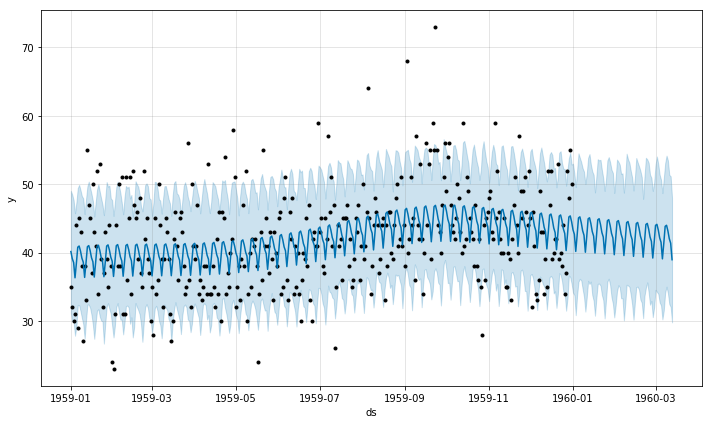

In [58]:
series = pd.read_csv('daily-total-female-births.csv', header=0, index_col=None)
series['ds']  = pd.to_datetime(series['Date'])
series[['y']] = series[['Births']].astype(float)
series = series[["ds","y"]]
evaluate_forecast(series,freq="D")

## Shampoo

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Training size 28 
Test size 8 


RMSE: 37.6723371452234


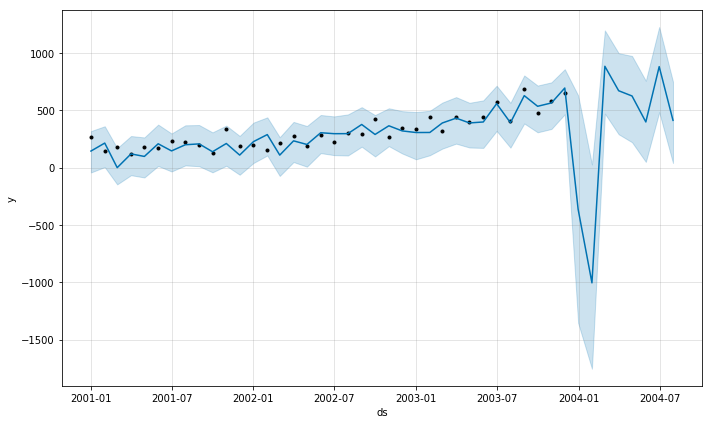

In [59]:
series = pd.read_csv('shampoo.csv', header=0)
series['ds']  = series['Month'].apply(lambda x: parse_date(x))
series[['y']] = series[['Sales']].astype(float)
series = series[["ds","y"]]
evaluate_forecast(series)

## Temp

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Training size 192 
Test size 48 
RMSE: 1.9148987239720643


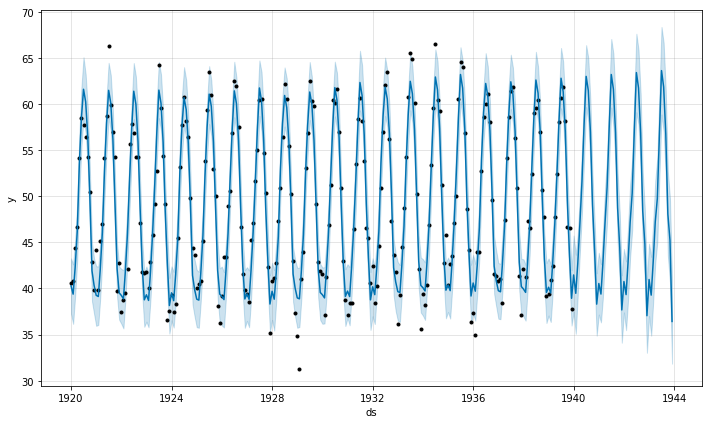

In [60]:
series = pd.read_csv('monthly-mean-temp.csv', header=0, index_col=None)
series['ds']  = pd.to_datetime(series['Month'])
series[['y']] = series[['Temperature']].astype(float)
series = series[["ds","y"]]
evaluate_forecast(series)

## Carsales

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Training size 86 
Test size 22 
RMSE: 1382.1358671296457


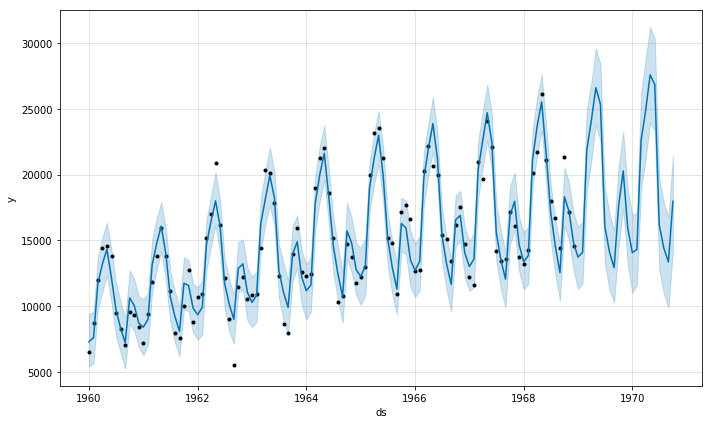

In [61]:
series = pd.read_csv('monthly-car-sales.csv', header=0,parse_dates=["Month"])
series['ds']  = series['Month']
series[['y']] = series[['Sales']].astype(float)
series = series[["ds","y"]]
evaluate_forecast(series)

# Singlestep Evaluation (TODO)

In [ ]:
series = pd.read_csv('monthly-mean-temp.csv', header=0, index_col=None)
series['ds']  = pd.to_datetime(series['Month'])
series[['y']] = series[['Temperature']].astype(float)
series = series[["ds","y"]]
#series = series[0:50]
data,prediction = find_best_solution(series,"temp")

# Simple demo

In [4]:
series = pd.read_csv('monthly-car-sales.csv', header=0, index_col=None)
#series["ds"] = series[["Month"]].apply(parse_date)
series['ds']  = pd.to_datetime(series['Month'])
series[['y']] = series[['Sales']].astype(float)
series = series[["ds","y"]]
series.head()

,ds,y
0,1960-01-01,6550.0
1,1960-02-01,8728.0
2,1960-03-01,12026.0
3,1960-04-01,14395.0
4,1960-05-01,14587.0


# Fit with prophet

In [ ]:
# Python
#m = Prophet()
m = Prophet(mcmc_samples=500,seasonality_mode='multiplicative').fit(series);

# Predict 

In [ ]:
series.tail()

In [ ]:
m.plot(forecast)

# Show seasonal Components

In [ ]:
m.plot_components(forecast)

In [ ]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m, horizon = '180 days')
df_cv.head()

In [ ]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p

In [ ]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')